<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Computer-Vision-Projects/blob/main/Download_satellite_image_sentinel_hub_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
! pip install sentinelhub

In [9]:
! sentinelhub.config --help

Usage: sentinelhub.config [OPTIONS]

  Inspect and configure parameters in your local sentinelhub configuration
  file

  Example:
    sentinelhub.config --show
    sentinelhub.config --instance_id <new instance id>
    sentinelhub.config --max_download_attempts 5 --download_sleep_time 20 --download_timeout_seconds 120

Options:
  --show                          Show current configuration
  --profile TEXT                  Selects profile to show/configure.
  --instance_id TEXT              Set new values to configuration parameter
                                  `instance_id`
  --sh_client_id TEXT             Set new values to configuration parameter
                                  `sh_client_id`
  --sh_client_secret TEXT         Set new values to configuration parameter
                                  `sh_client_secret`
  --sh_base_url TEXT              Set new values to configuration parameter
                                  `sh_base_url`
  --sh_auth_base_url TEXT         Set

In [10]:
! sentinelhub.config --show

{
  "instance_id": "",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "sh_auth_base_url": null,
  "sh_token_url": "https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_session_token": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5.0,
  "download_timeout_seconds": 120.0,
  "number_of_download_processes": 1,
  "max_retries": null
}
Configuration file location: /root/.config/sentinelhub/config.toml


In [12]:
from sentinelhub import SHConfig

Client_id = '8e0bbe12-838a-461c-9013-a19a28029482'
Client_secret = 'dmIWT68DqA3t6gaqQoXIq3aJubk7x6vj'

In [13]:
config = SHConfig()

if Client_id and Client_secret:
  config.sh_client_id = Client_id
  config.sh_client_secret = Client_secret

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

## Imports

In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from __future__ import annotations

from typing import Any

import matplotlib.pyplot as plt
import numpy as np


def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [17]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
# from utils import plot_image

## Setting area of interest

> Bbox: `http://bboxfinder.com/`

In [24]:
betsiboka_coords_wgs84 = (46.16, -16.15, 46.51, -15.58)

In [25]:
resolution = 60
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {betsiboka_size} pixels")

Image shape at 60 m resolution: (631, 1047) pixels


## Example 1: True color (PNG) on a specific date

In [32]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A, #L1C
            time_interval=("2024-04-01", "2024-04-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [33]:
true_color_imgs = request_true_color.get_data()

In [34]:
print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1047, 631, 3)


Image type: uint8


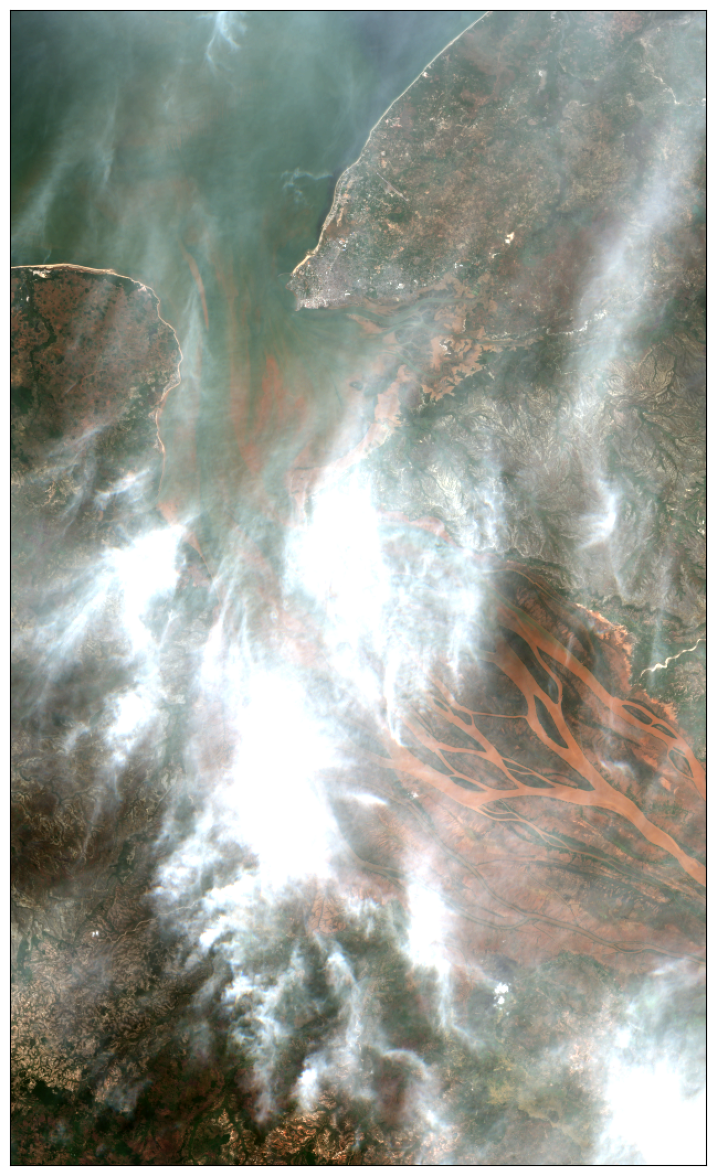

In [35]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))

## Example 1.1 Adding cloud mask data

In [37]:
evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "CLM"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.CLM == 1) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
}
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2024-04-01", "2024-04-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [38]:
data_with_cloud_mask = request_true_color.get_data()

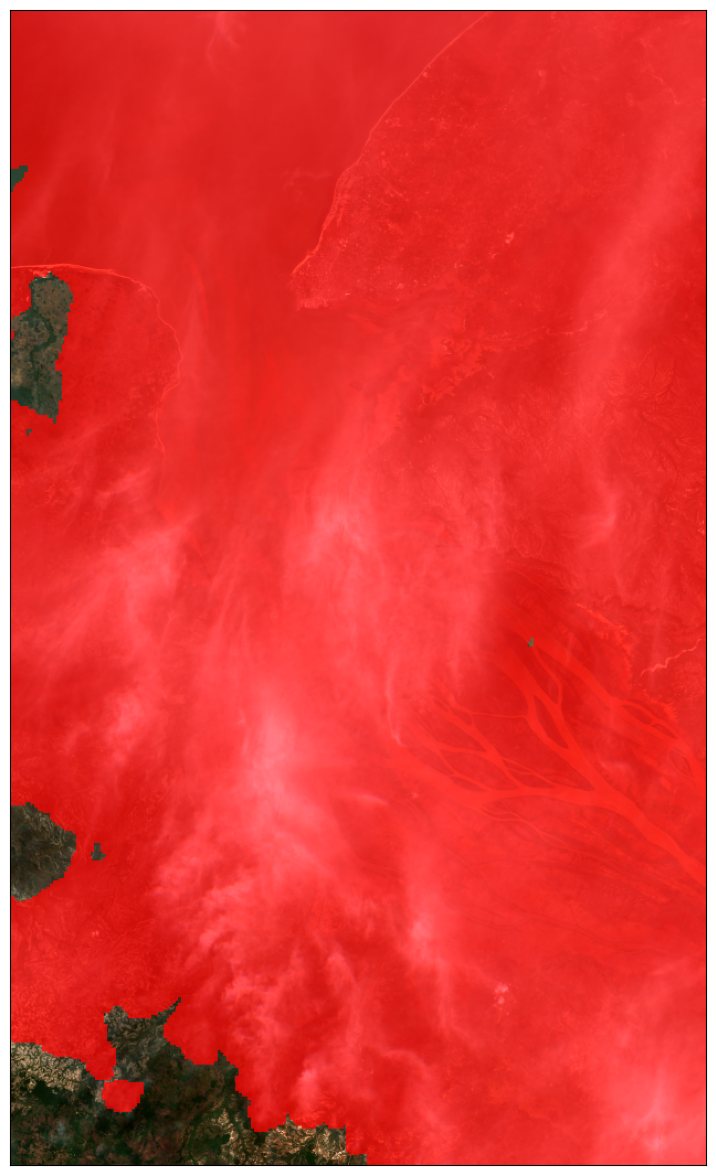

In [39]:
plot_image(data_with_cloud_mask[0], factor=1 / 255)

## Example 2: True color mosaic of least cloudy acquisitions

In [42]:
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2024-04-01", "2024-04-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

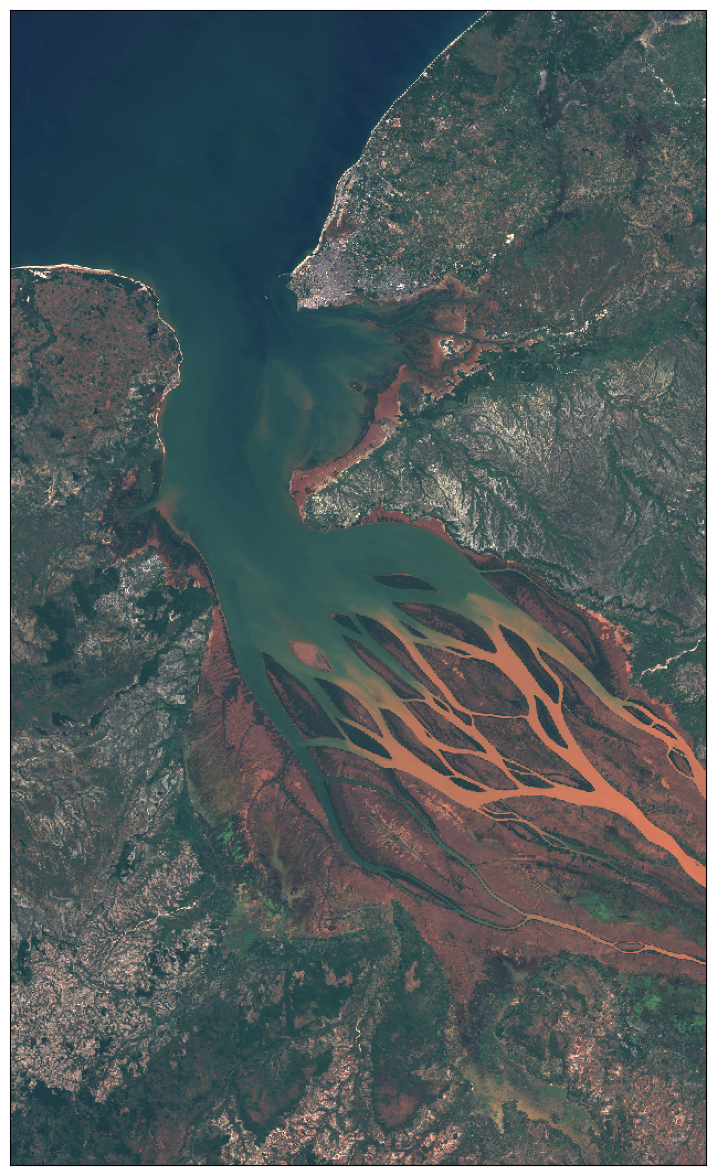

In [43]:
plot_image(request_true_color.get_data()[0], factor=3.5 / 255, clip_range=(0, 1))

## Example 3 : Multiple timestamps data

In [45]:
start = datetime.datetime(2024, 1, 1)
end = datetime.datetime(2024, 4, 30)
n_chunks = 13
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2024-01-01', '2024-01-10')
('2024-01-10', '2024-01-19')
('2024-01-19', '2024-01-28')
('2024-01-28', '2024-02-06')
('2024-02-06', '2024-02-16')
('2024-02-16', '2024-02-25')
('2024-02-25', '2024-03-05')
('2024-03-05', '2024-03-14')
('2024-03-14', '2024-03-24')
('2024-03-24', '2024-04-02')
('2024-04-02', '2024-04-11')
('2024-04-11', '2024-04-20')


In [46]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=betsiboka_bbox,
        size=betsiboka_size,
        config=config,
    )

In [47]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

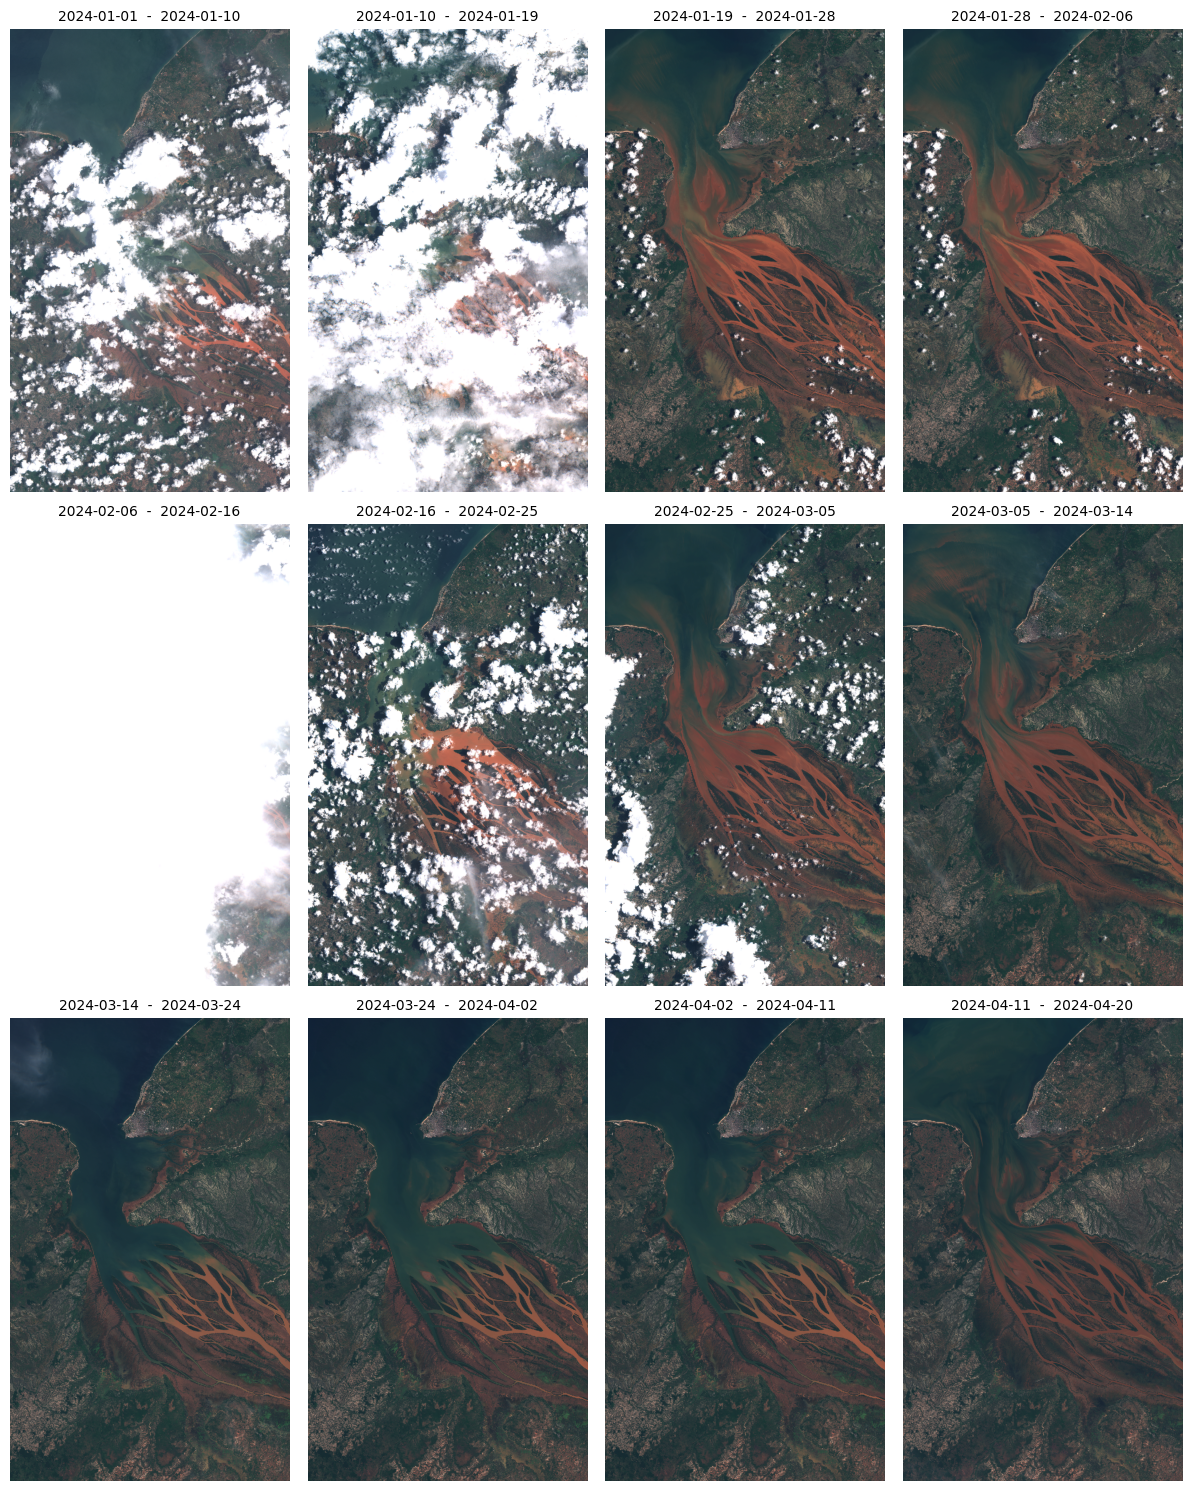

In [48]:
# some stuff for pretty plots
ncols = 4
nrows = 3
aspect_ratio = betsiboka_size[0] / betsiboka_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

## Example 4: Save downloaded data to disk and read it from disk

In [54]:
request_true_color = SentinelHubRequest(
    data_folder="test_dir",
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=("2024-04-01", "2024-04-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config,
)

In [55]:
%%time
all_bands_img = request_true_color.get_data(save_data=True)

CPU times: user 120 ms, sys: 4.62 ms, total: 125 ms
Wall time: 3.32 s


In [56]:
print(
    "The output directory has been created and a tiff file with all 13 bands was saved into the following structure:\n"
)

for folder, _, filenames in os.walk(request_true_color.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

test_dir/29c883ba6c3db2f8a281ca188317a850/request.json
test_dir/29c883ba6c3db2f8a281ca188317a850/response.png
test_dir/625bc50227b176b2fdb13db09691f4d1/request.json
test_dir/625bc50227b176b2fdb13db09691f4d1/response.png
